# Processing of 10x Data to Generate Heatmap

Here, I process the 5' liver from 10x. We decided to use the 5' data because Derek showed good projection overlap of that dataset with the 10x using the ingest function. I analyze the 5' 10x dataset using all available genes.

In [2]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
# from IPython.display import display, HTML
# import bbknn
import time

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

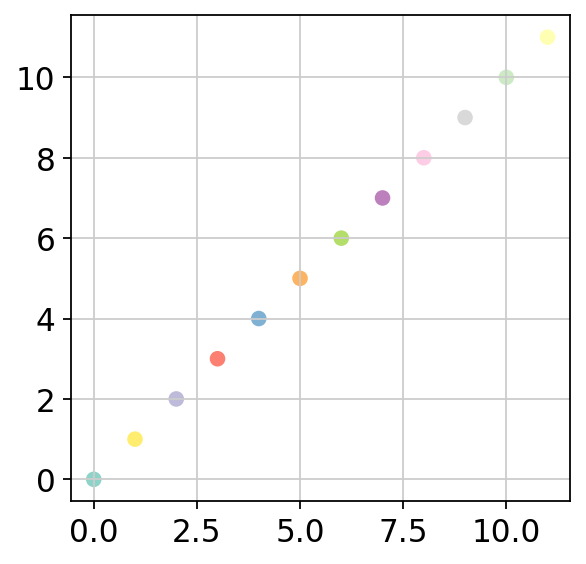

In [4]:
plt.scatter(np.arange(12), np.arange(12), c=['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3'])
colors = dict(zip(['turq','dark yel','light purp','coral','blue','orange','light gr','purp','pink','gray','mint','light yel'],
                  ['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3']))

# Load in the Datasets

### Load in the 10x data

For some reason, the `h5` that I got from Derek had some issues, it was only reading it as a `view` and not an `actual`. I loaded it in and fixed it, and re-exported for easier loading later. 

In [5]:
data = dict()
data['adata'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5')
data['adata'] = data['adata'].copy() # for some reason, read_10x_h5 only loads a view, not an actual object. this converts to an object
data['adata'].var_names_make_unique()
data['adata_original'] = data['adata'].copy()

data['adata_h'] = data['adata']
data['adata_h'].var_names_make_unique()
data['adata_h'] = data['adata_h'][:, [i for i in data['adata'].var_names if i.startswith('GRCh38_')]].copy()

data['adata_m'] = data['adata']
data['adata_m'].var_names_make_unique()
data['adata_m'] = data['adata_m'][:, [i for i in data['adata'].var_names if i.startswith('mm10___')]].copy()

reading /data/xyzeq/10x/5prime_liver/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Visualize the knee plot to draw a cutoff for the 10x cells. There was high background in this data.

In [6]:
for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data[adata], min_counts=1)
    sc.pp.filter_genes(data[adata], min_counts=1)
    data[adata + '-filter_cells_n_counts'] = data[adata].obs['n_counts'].sort_values(ascending=False)

filtered out 533042 cells that have less than 1 counts
filtered out 13298 genes that are detected in less than 1 counts
filtered out 519834 cells that have less than 1 counts
filtered out 12235 genes that are detected in less than 1 counts


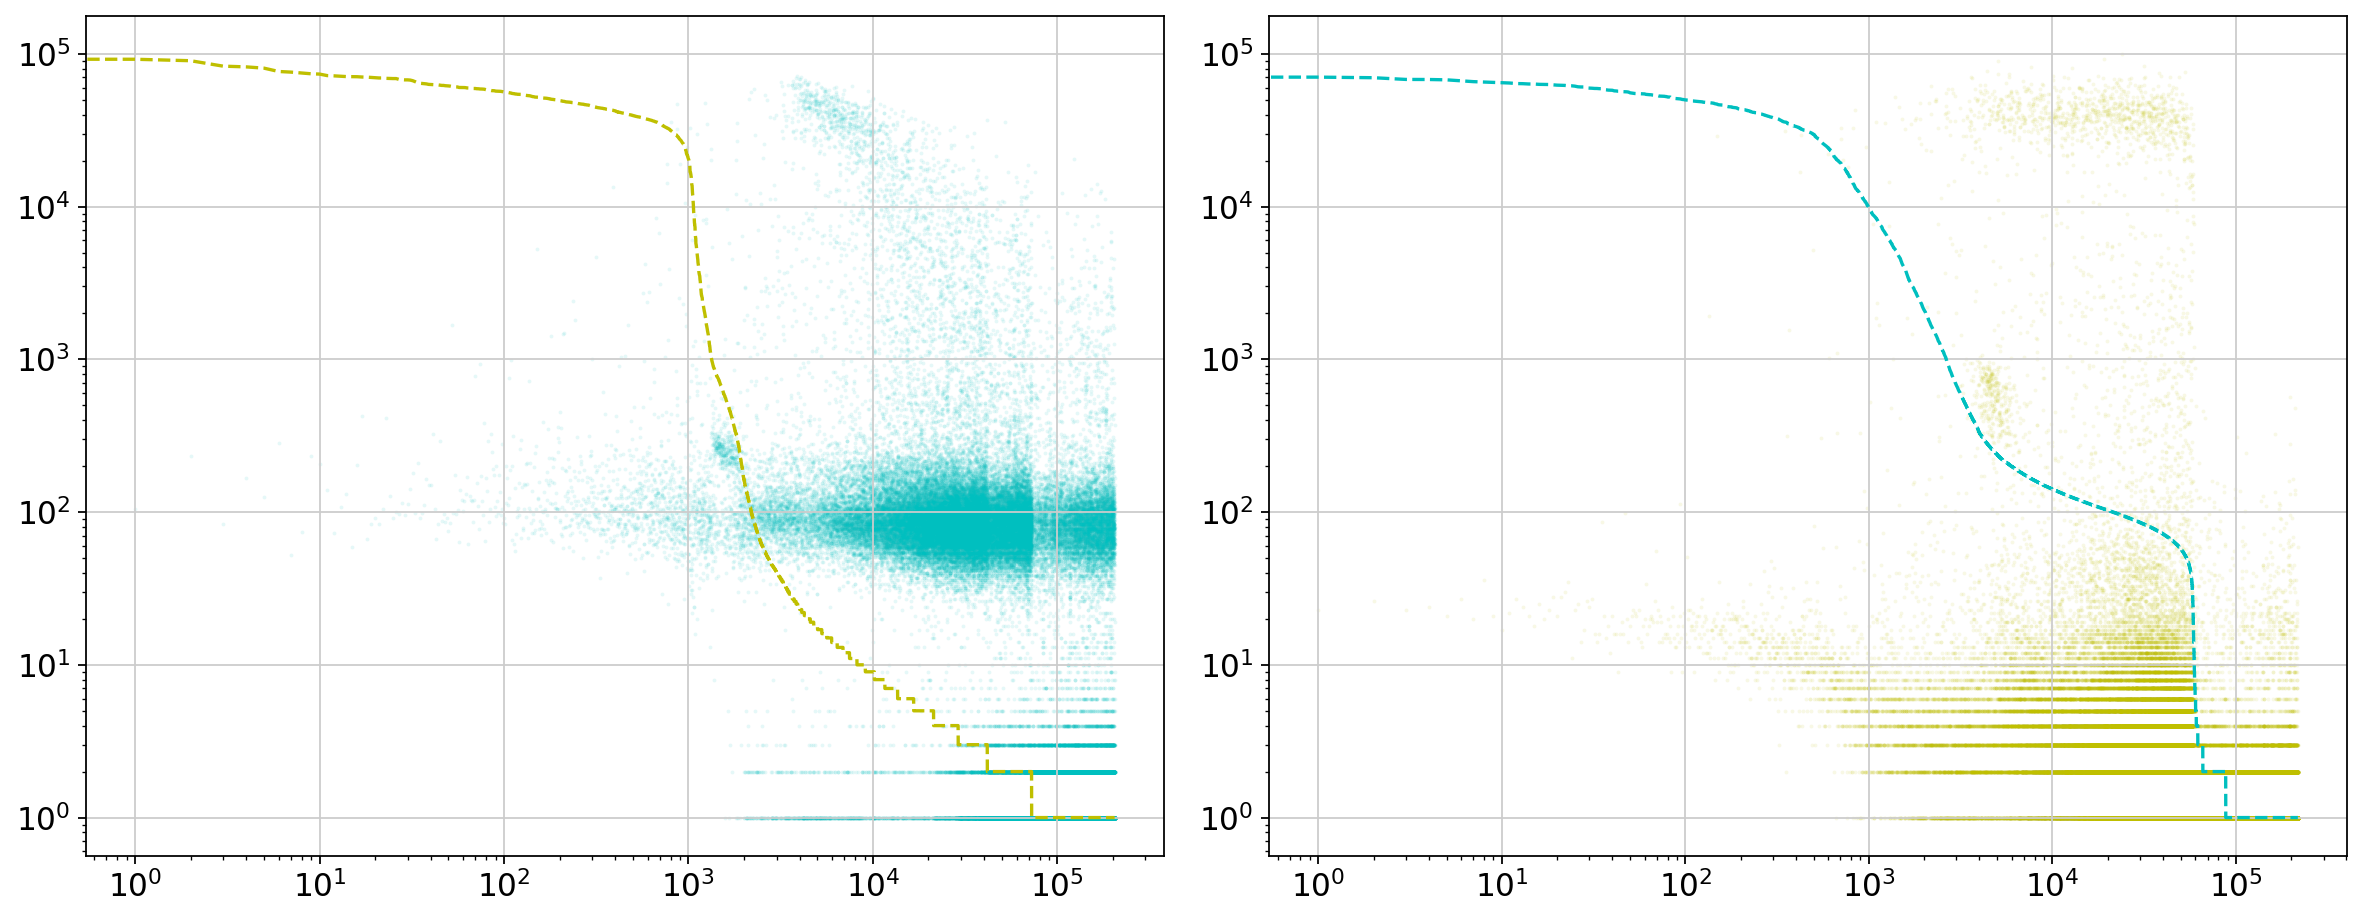

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for prod, ax in tqdm(list(zip(['adata_h', 'adata_m'], np.ravel(ax.T))), total=2):
    series = data[prod + '-filter_cells_n_counts']
    if prod == 'adata_h':
        ax.scatter(range(len(series)), data['adata_m'].obs['n_counts'][series.index.values].values, color='c', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='y', linestyle='--')
    else:
        ax.scatter(range(len(series)), data['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()

In [8]:
mouse_hi_umi_cells = data['adata_m'].obs_names[data['adata_m'].obs['n_counts'] > 5e2].values
lo_umi_human_cells = data['adata_h-filter_cells_n_counts'][2000:].index.values

In [9]:
human_hi_umi_cells = data['adata_h'].obs_names[data['adata_h'].obs['n_counts'] > 1e3].values
lo_umi_mouse_cells = data['adata_m-filter_cells_n_counts'][2000:].index.values

In [10]:
mouse_cells = np.intersect1d(mouse_hi_umi_cells, lo_umi_human_cells)
human_cells = np.intersect1d(human_hi_umi_cells, lo_umi_mouse_cells)

In [11]:
data['adata_m'] = data['adata_m'][mouse_cells,:].copy()
data['adata_h'] = data['adata_h'][human_cells,:].copy()

In [12]:
data['adata_m'].var_names = [i[7:] for i in data['adata_m'].var_names]
data['adata_h'].var_names = [i[7:] for i in data['adata_h'].var_names]

Threshold %mito.

In [13]:
genelist = data['adata_m'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['adata_m'][:, mito_genes].X, axis=1))

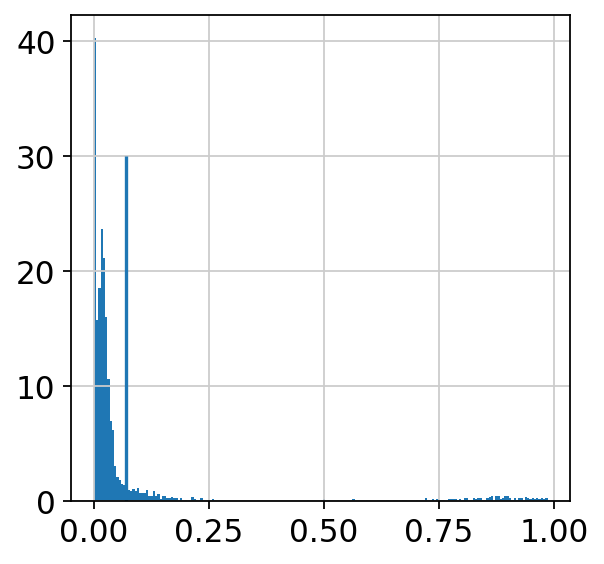

In [14]:
data['adata_m'].obs['percent_mito'] = mito_counts / data['adata_m'].obs['n_counts'].values
plt.hist(data['adata_m'].obs['percent_mito'].values,bins=200,density=True);
plt.vlines(0.07, 0, 30);

In [15]:
genelist = data['adata_h'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['adata_h'][:, mito_genes].X, axis=1))

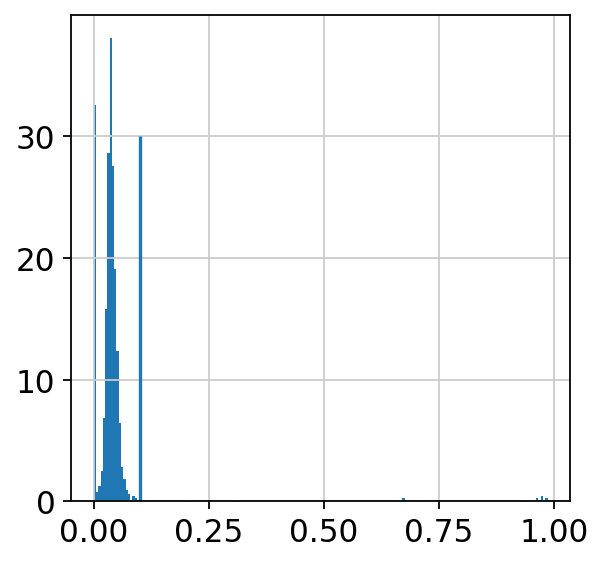

In [16]:
data['adata_h'].obs['percent_mito'] = mito_counts / data['adata_h'].obs['n_counts'].values
plt.hist(data['adata_h'].obs['percent_mito'].values,bins=200,density=True);
plt.vlines(0.1, 0, 30);

In [17]:
data['adata_h'] = data['adata_h'][data['adata_h'].obs['percent_mito'] < 0.1].copy()
data['adata_m'] = data['adata_m'][data['adata_m'].obs['percent_mito'] < 0.07].copy()

In [18]:
vals_h = data['adata_h'].var['n_counts'].sort_values(ascending=False).values
vals_m = data['adata_m'].var['n_counts'].sort_values(ascending=False).values

In [19]:
for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data[adata], min_counts=1)
    sc.pp.filter_genes(data[adata], min_counts=1)

filtered out 162 genes that are detected in less than 1 counts
filtered out 290 genes that are detected in less than 1 counts


Put back genome identifiers on gene names.

In [20]:
data['adata_m'].var_names = ['m_' + i for i in data['adata_m'].var_names]
data['adata_h'].var_names = ['H_' + i for i in data['adata_h'].var_names]

In [21]:
data['adata'] = data['adata_m'].concatenate(data['adata_h'],join='outer')

In [22]:
data['adata'].obs_names = [i[:18] for i in data['adata'].obs_names]

In [23]:
data['adata_original'][data['adata'].obs_names,:].copy()[:, [i for i in data['adata_original'].var_names if i.startswith('GRCh38_')]].X.sum(axis=1)

matrix([[6.0000e+00],
        [3.0000e+00],
        [4.0000e+00],
        ...,
        [3.7569e+04],
        [3.1561e+04],
        [1.2830e+03]], dtype=float32)

In [24]:
data['adata'].obs['n_counts_H'] = data['adata_original'][data['adata'].obs_names,:].copy()[:, [i for i in data['adata_original'].var_names if i.startswith('GRCh38_')]].X.sum(axis=1)
data['adata'].obs['n_counts_m'] = data['adata_original'][data['adata'].obs_names,:].copy()[:, [i for i in data['adata_original'].var_names if i.startswith('mm10___')]].X.sum(axis=1)

Add a raw attribute, then log the data and normalize per cell.

In [25]:
data['adata_raw'] = data['adata'].copy()

In [26]:
sc.pp.log1p(data['adata'])
sc.pp.normalize_per_cell(data['adata'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [27]:
sc.pp.log1p(data['adata_m'])
sc.pp.normalize_per_cell(data['adata_m'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [28]:
sc.pp.log1p(data['adata_h'])
sc.pp.normalize_per_cell(data['adata_h'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Dimensionality Reduction and Clustering

In [29]:
data['adata_unscaled'] = data['adata'].copy()

In [30]:
data['adata_unscaled'].write_h5ad(prefix + '/10x/5prime_liver/10x.unscaled.h5ad')

... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical


In [31]:
sc.pp.scale(data['adata'], max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10


computing PCA
    with n_comps=100
    finished (0:00:25)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


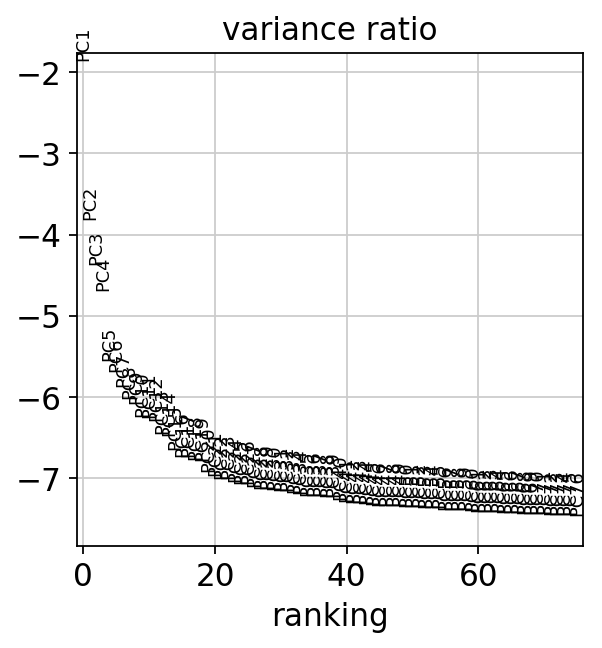

In [32]:
warnings.filterwarnings('ignore')
sc.pp.pca(data['adata'],n_comps=100)
sc.pl.pca_variance_ratio(data['adata'],log=True, n_pcs=75)
warnings.filterwarnings('default')

In [33]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(data['adata'],n_neighbors=15,n_pcs=50) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [34]:
sc.tl.umap(data['adata'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [56]:
sc.tl.leiden(data['adata'],resolution=1)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


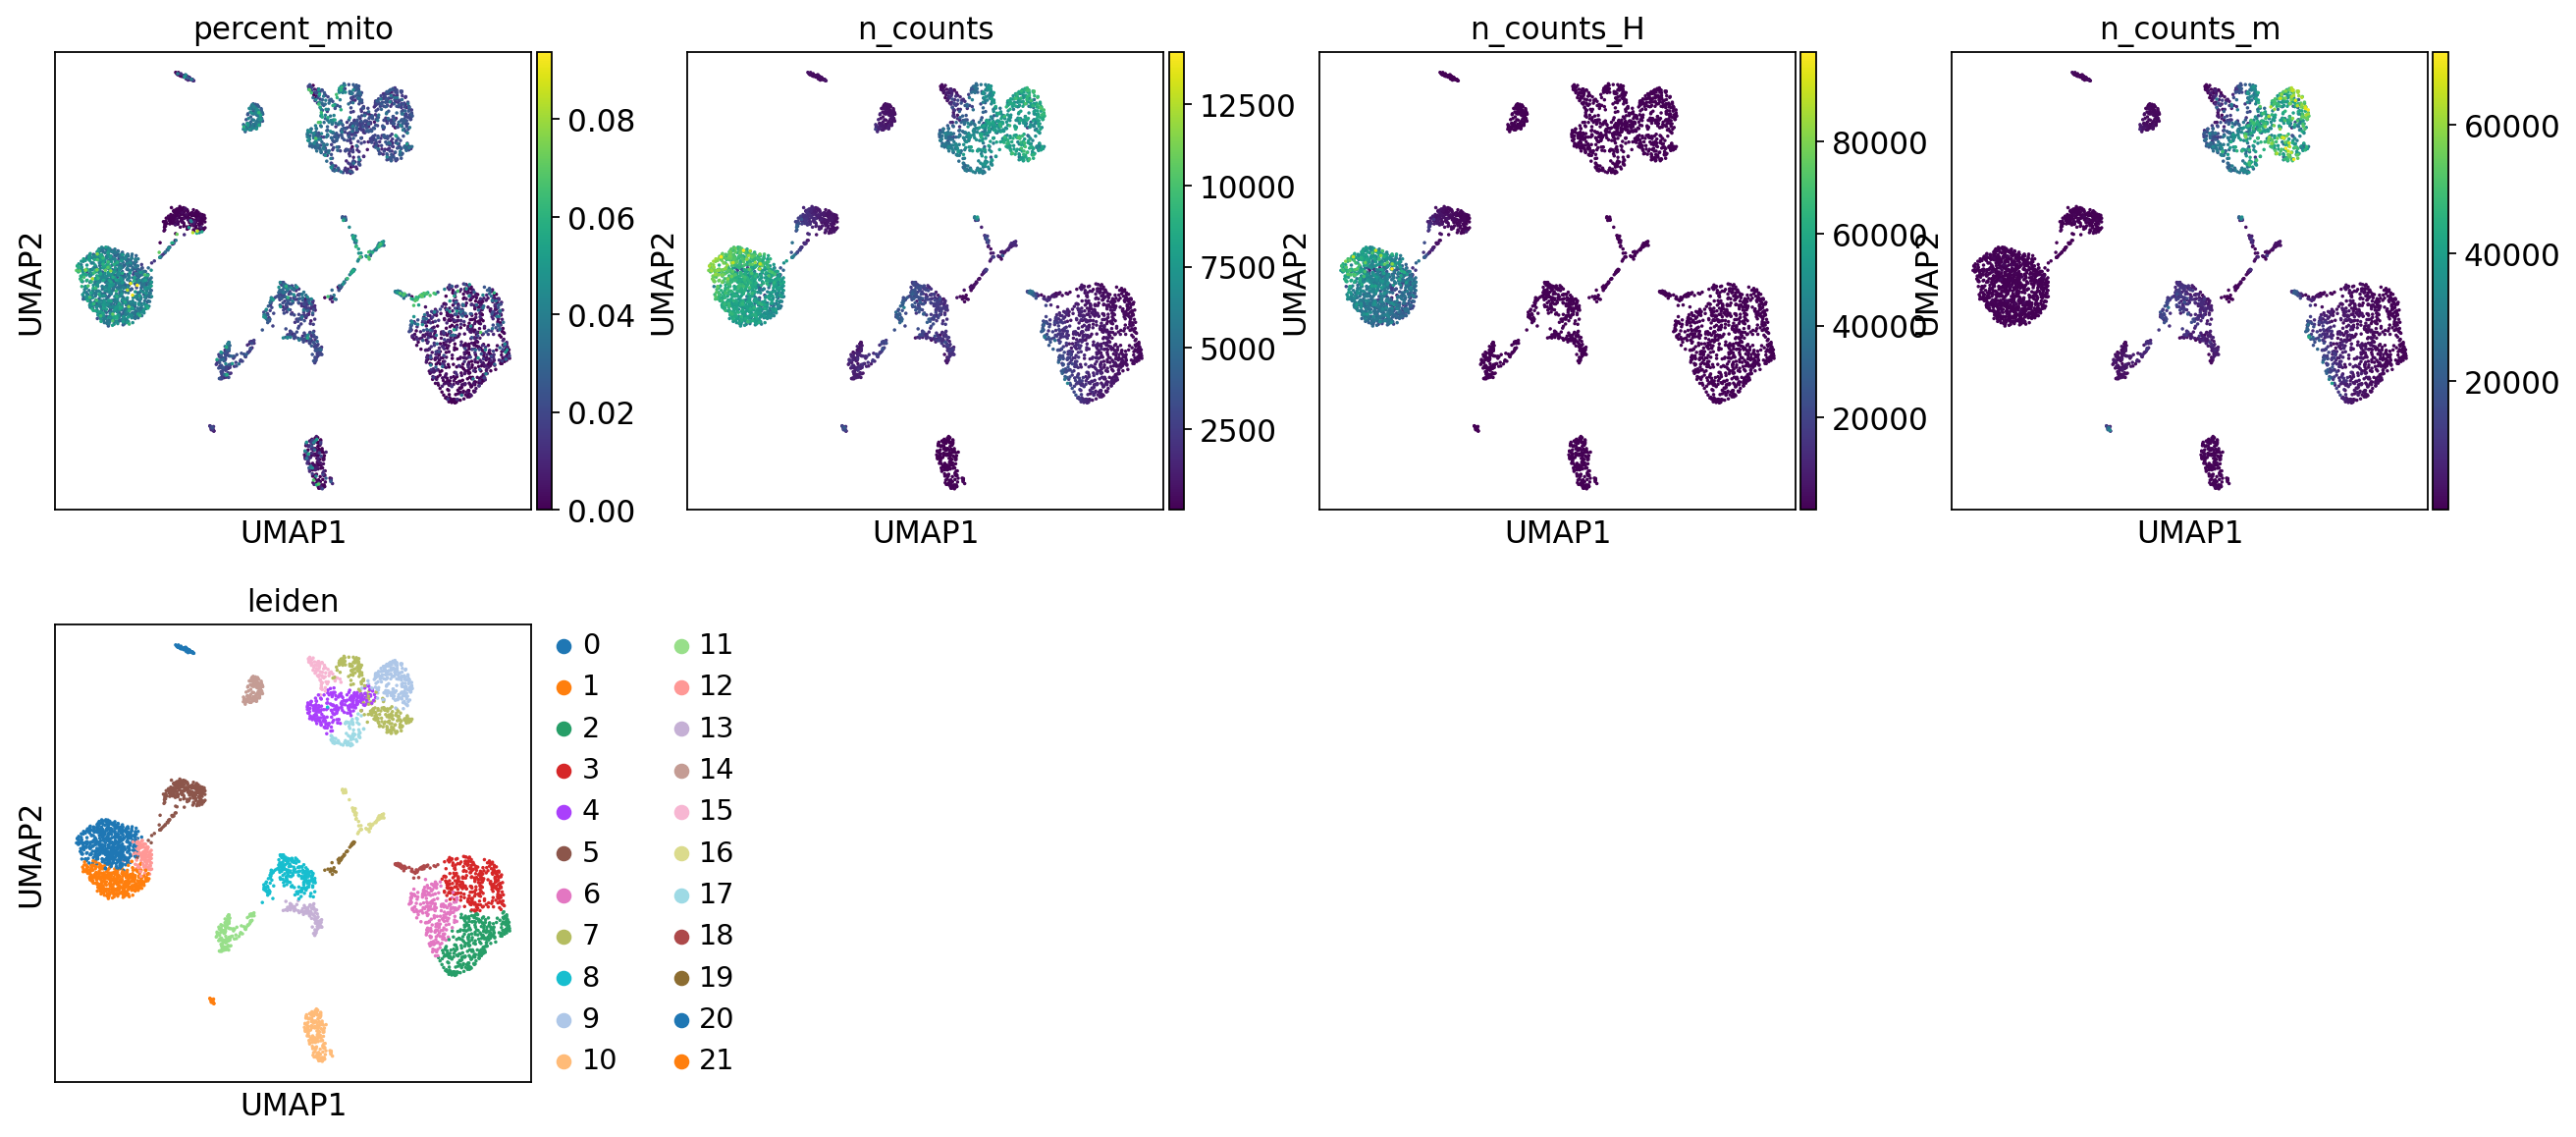

In [52]:
sc.pl.umap(data['adata'],color=['percent_mito', 'n_counts', 'n_counts_H', 'n_counts_m', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

After exploring the gene sets enriched in each cluster, I've annotated them and now will group them together for a common annotation.

In [57]:
groupings = [[0, 1, 5, 12],
             [4, 7, 9, 15, 17],
             [2, 3, 6, 18],
             ]

grouped_clusts = [i for j in groupings for i in j]
numclusts = np.unique(data['adata'].obs['leiden'].values.astype(int))
for i in np.setdiff1d(numclusts, grouped_clusts):
    groupings.append([i])

In [58]:
ctdict = dict()
for i in range(len(groupings)):
    ctdict['ct%s' % str(i)] = groupings[i]

data['adata'].obs['celltype'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['celltype'].replace(str(clust), ct, regex=True, inplace=True)
data['adata'].obs['leiden'] = [i.strip('ct') for i in data['adata'].obs['celltype'].astype('category')]

### Annotation

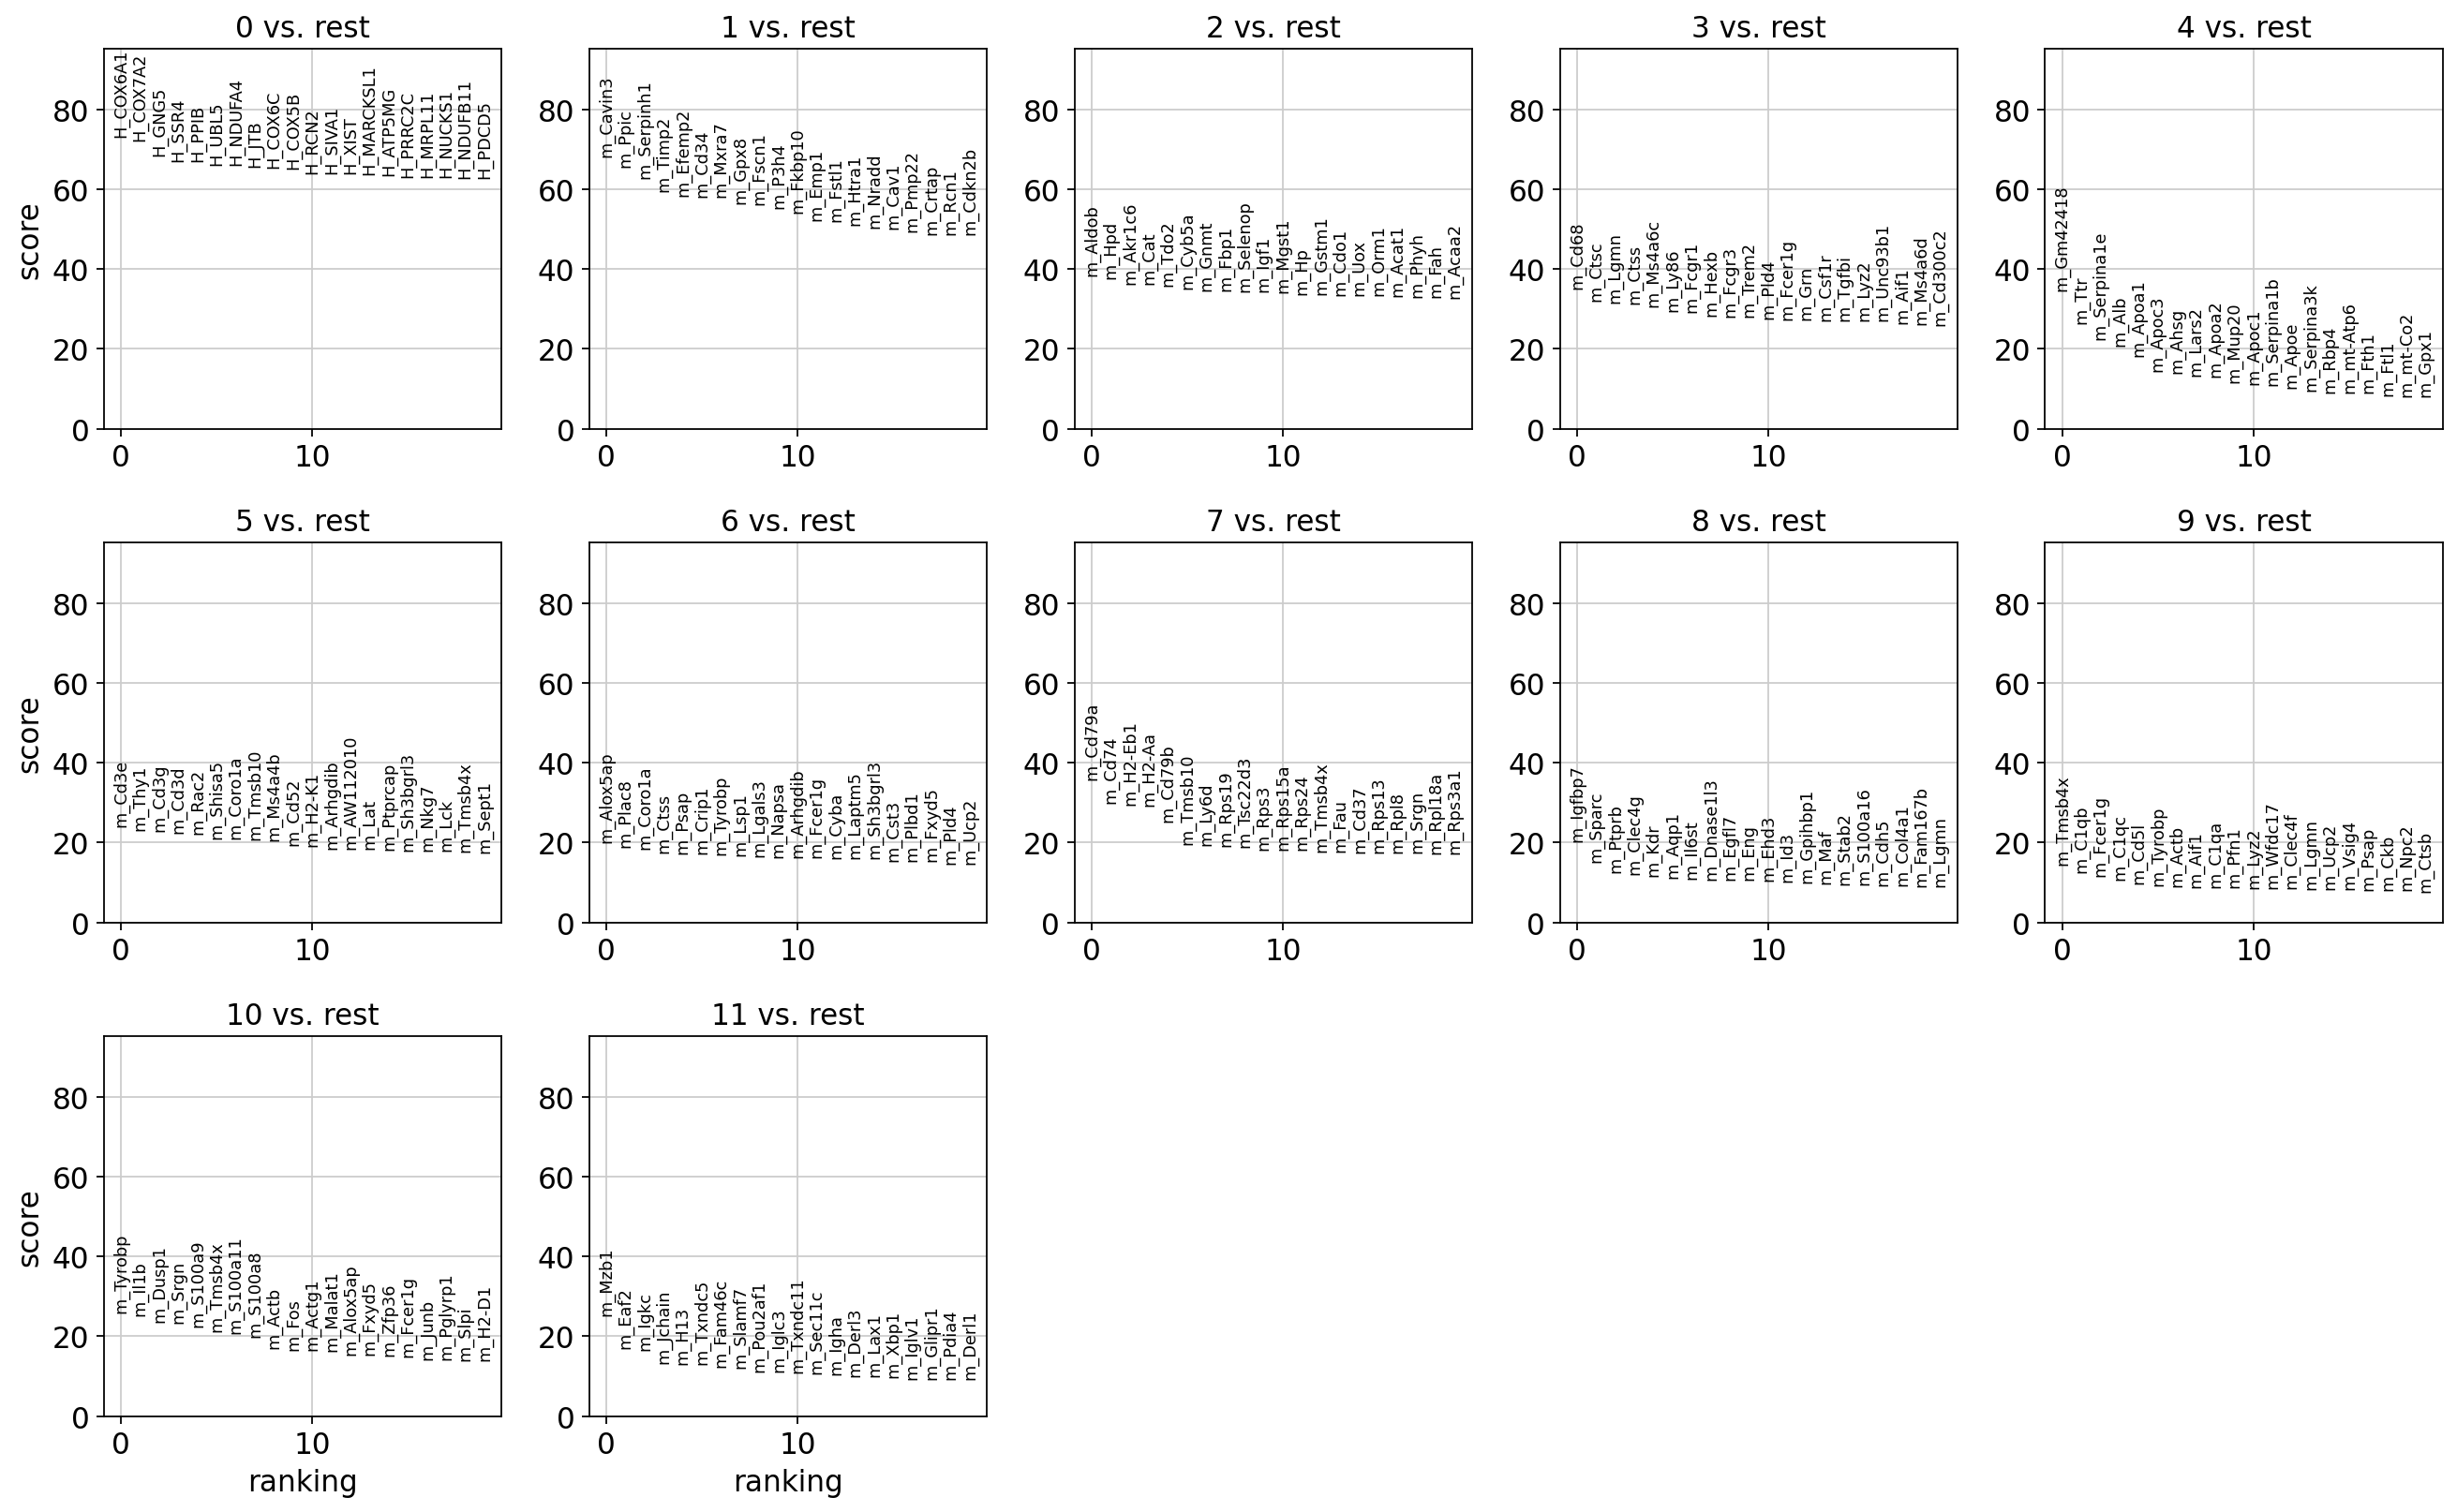

In [61]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['adata'], groupby='leiden', n_genes=1000)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['adata'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [110]:
ctdict = dict()
ctdict['HEK293T'] = [0]
ctdict['HEPATOCYTE'] = [2, 4]
ctdict['MC38'] = [1]
ctdict['MPHAGE'] = [3, 6]
ctdict['PLASMA CELL'] = [11]
ctdict['B CELL'] = [7]
ctdict['KUPFFER'] = [9]
ctdict['LSEC'] = [8]
ctdict['GRANULOCYTE'] = [10]
ctdict['T CELL'] = [5]
data['adata'].obs['celltype2'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['celltype2'].replace(str(clust),'10X_%s' % ct,regex=True, inplace=True)
data['adata'].obs['celltype2'] = data['adata'].obs['celltype2'].astype('category')

In [111]:
colors

{'turq': '#8DD3C7',
 'dark yel': '#FFED6F',
 'light purp': '#BEBADA',
 'coral': '#FB8072',
 'blue': '#80B1D3',
 'orange': '#FDB462',
 'light gr': '#B3DE69',
 'purp': '#BC80BD',
 'pink': '#FCCDE5',
 'gray': '#D9D9D9',
 'mint': '#CCEBC5',
 'light yel': '#FFFFB3'}

In [112]:
data['adata'].uns['celltype2_colors'] = [
    colors['turq'],
    colors['pink'],
    colors['gray'],
    colors['coral'],
    colors['dark yel'],
    colors['light gr'],
    colors['blue'],
    colors['orange'],
    colors['mint'],
    colors['purp'],
]

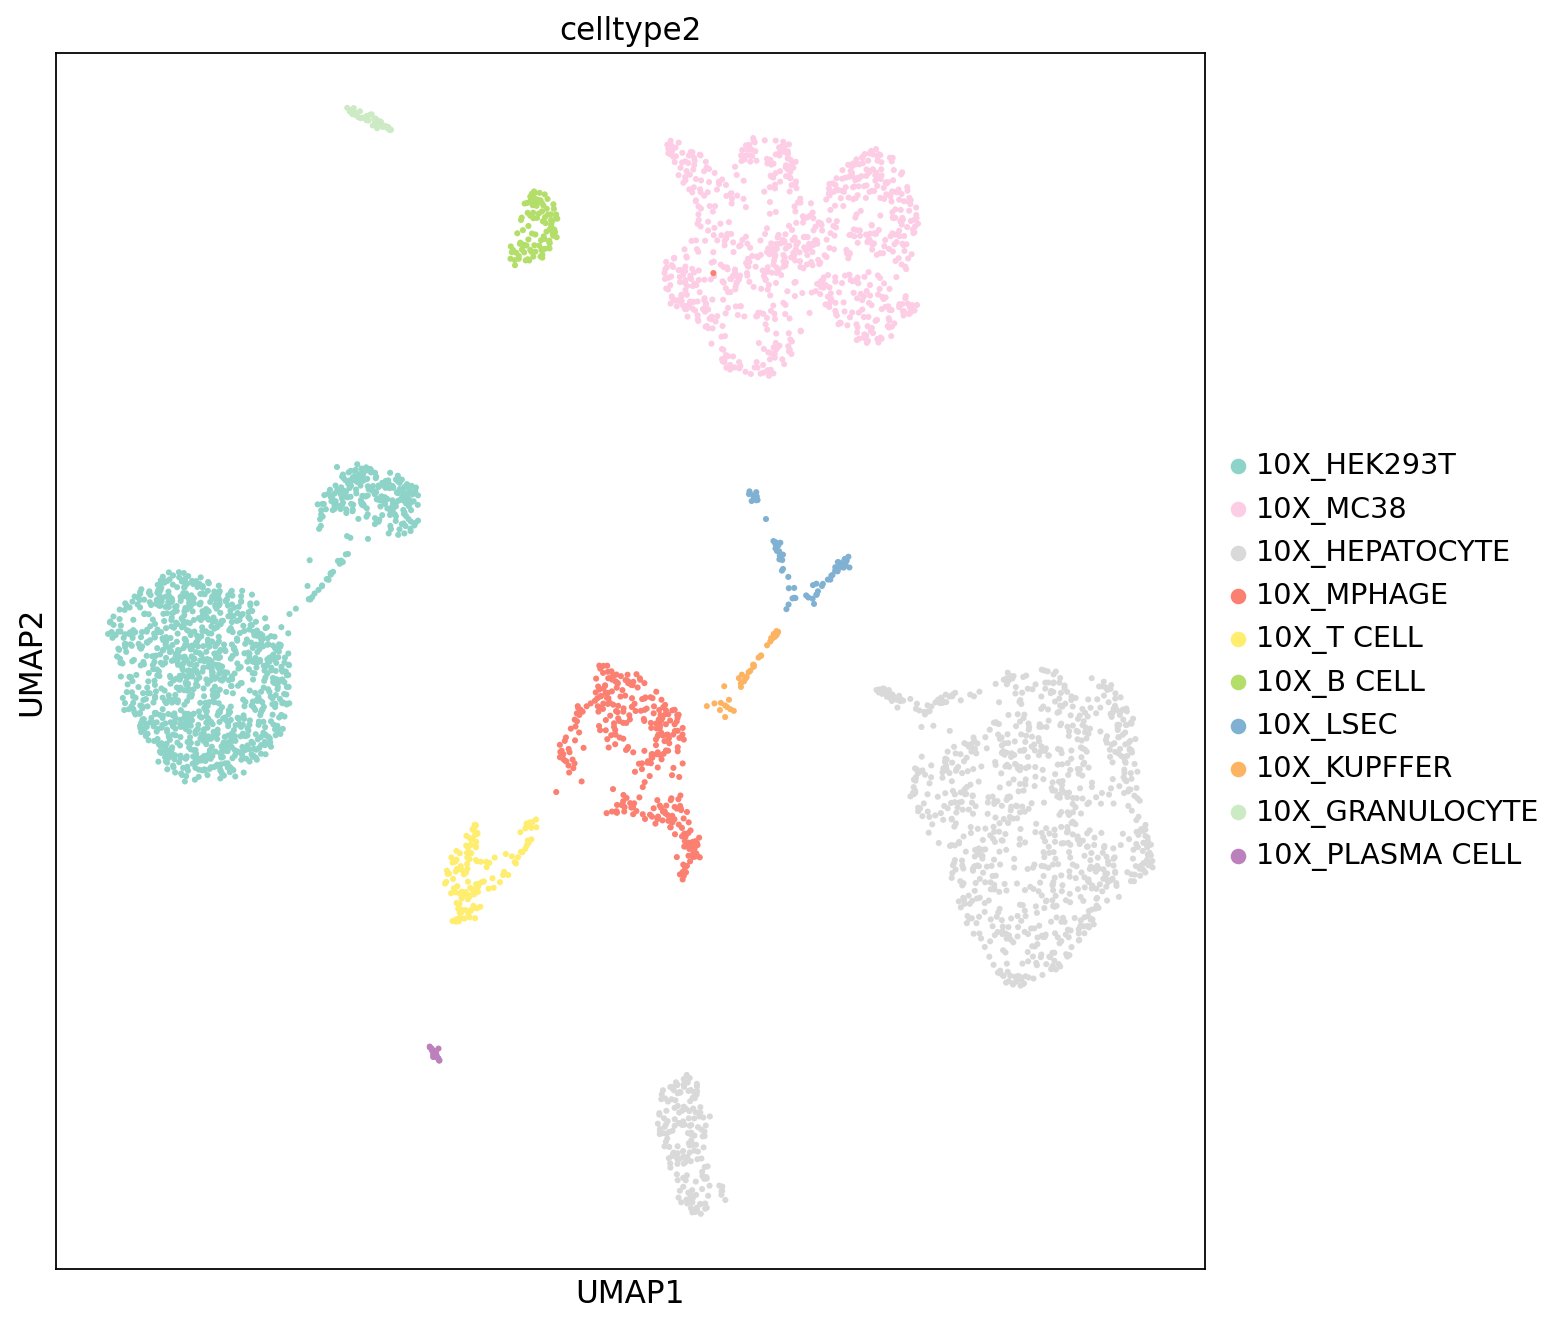

In [113]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.umap(data['adata'],color=['celltype2'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
# plt.savefig(prefix + '10x/2020112/figures/10x.umap.pdf')

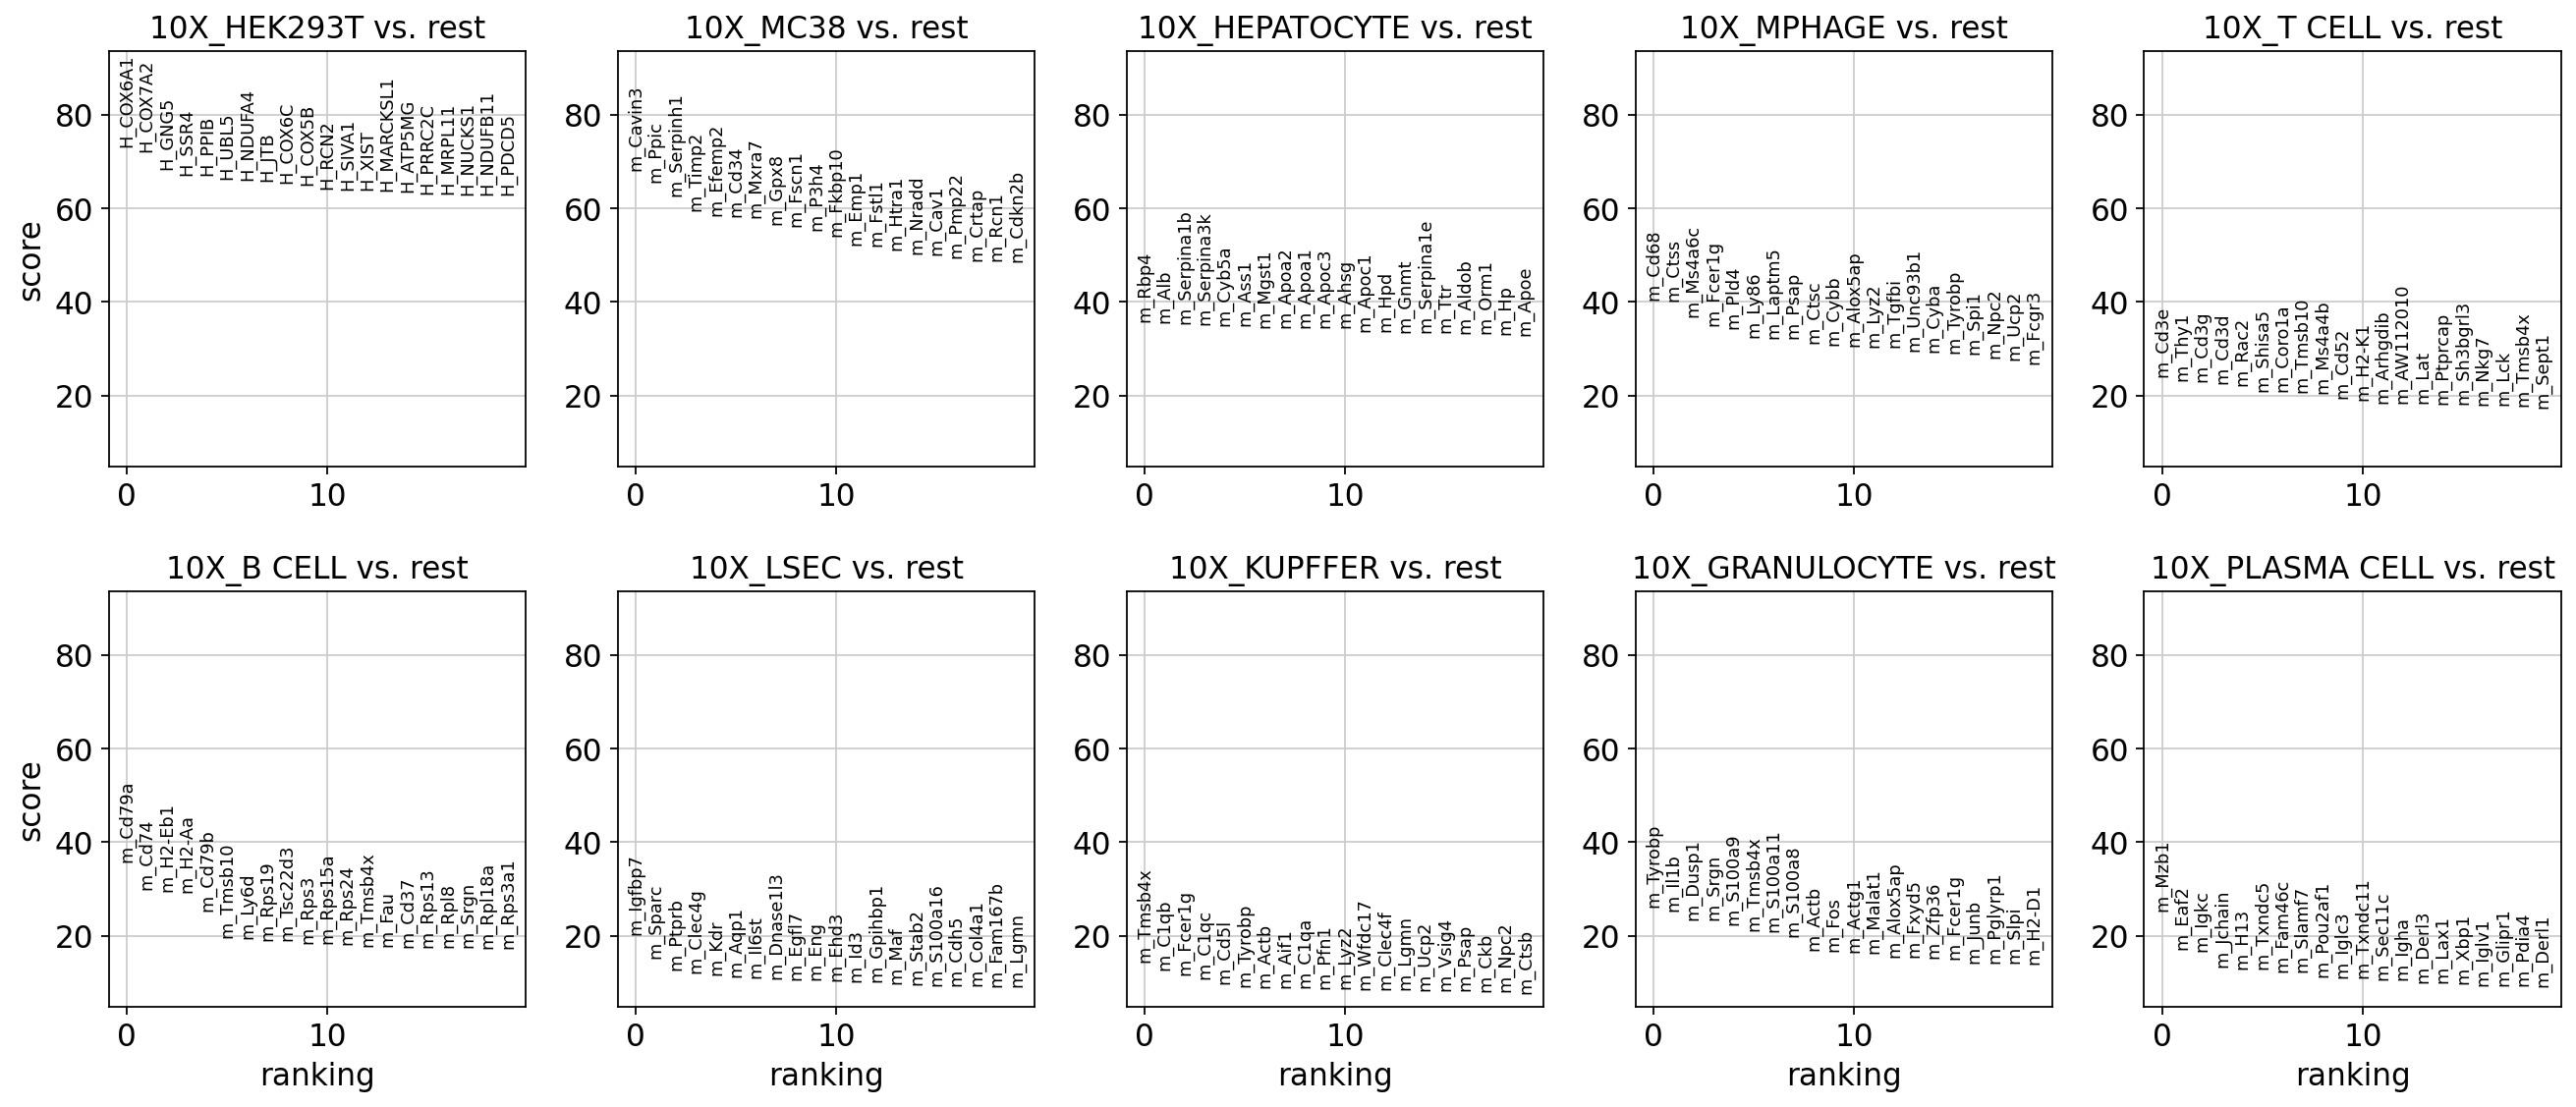

In [114]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['adata'], groupby='celltype2', use_raw=False)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['adata'], ncols=5)
sc.settings.verbosity = 3

In [3]:
# with open('/data/xyzeq/box.data2/data/10x.data.gh.pkl', 'wb') as file:
#     pkl.dump(data, file, protocol=4)
with open('/data/xyzeq/box.data2/data/10x.data.gh.pkl', 'rb') as file:
    data = pkl.load(file)